In [1]:
from IPython.display import HTML
import subprocess

branch = subprocess.check_output(["git", "rev-parse", "--abbrev-ref", "HEAD"]).decode()[:-1]
HTML('<a href="https://colab.research.google.com/github/ArielFix/DLINtroProject/blob/{branch}/NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>'.format(branch=branch))

## Notes:
* Running may require commands in the bottom of the notebook first


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import feature_extraction, linear_model, model_selection, preprocessing

ModuleNotFoundError: No module named 'numpy'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
train_path = '/content/gdrive/MyDrive/NLP_Project/data/train.csv'
test_path = '/content/gdrive/My Drive/NLP_Project/data/test.csv'
sample_submission_path = '/content/gdrive/MyDrive/NLP_Project/data/sample_submission.csv'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
#print(train_df.to_string())
#print(test_df.to_string())

**A quick look at our data**
Let's look at our data... first, some examples of what is NOT a disaster tweet.

In [ ]:
print('\n' .join(map(str, train_df[train_df["target"] == 0]["text"].values[0:5])))


What's up man?
I love fruits
Summer is lovely
My car is so fast
What a goooooooaaaaaal!!!!!!


And some examples of what is a disaster tweet.

In [ ]:
print('\n' .join(map(str, train_df[train_df["target"] == 1]["text"].values[0:5])))

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Forest fire near La Ronge Sask. Canada
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
13,000 people receive #wildfires evacuation orders in California 
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 


The words contained in each tweet are a good indicator of whether they're about a real disaster or not. This is not entirely correct, but it's a great place to start.

We'll use scikit-learn's `CountVectorizer` to count the words in each tweet and turn them into data our machine learning model can process.

In [ ]:
train_df, val_df = model_selection.train_test_split(train_df)
count_vectorizer = feature_extraction.text.CountVectorizer()

## let's get counts for the first 5 tweets in the data
example_train_vectors = count_vectorizer.fit_transform(train_df["text"][0:5])
print('The first 5 tweets in the data: \n')
print('\n' .join(map(str, train_df["text"][0:5])))
print('\n')
## we use .todense() here because these vectors are "sparse" (only non-zero elements are kept to save space)
print(example_train_vectors[0].todense().shape)
print(example_train_vectors[0].todense())

The first 5 tweets in the data: 

i hate people who tweet 'receipts' but KNOW its wrong

but they wont take it down bc it 'blew up'
literally gtfo you're that desperate
Ina Buted Girl Crush??
@phnotf sometimes your cheekiness bleeds through my computer screen and i recoil in fear
I liked a @YouTube video http://t.co/z8Cp77lVza Boeing 737 takeoff in snowstorm. HD cockpit view + ATC audio - Episode 18
The hurricane mixxtail kinda tastes like the watermelon four loko. ???????? @brittsand9


(1, 67)
[[0 0 0 0 0 1 0 1 0 0 2 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 2 1 0 1 0 0
  1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 1 0 1 0 1 1 0 0 0 1 1 1 1 0 0 0]]


**The above tells us that:**

1.   There are 54 unique words (or "tokens") in the first five tweets.
2.   The first tweet contains only some of those unique tokens - all of the non-zero counts above are the tokens that DO exist in the first tweet.

Now let's create vectors for all of our tweets.

In [ ]:
train_vectors = count_vectorizer.fit_transform(train_df["text"])

## note that we're NOT using .fit_transform() on test_df. Using just .transform() makes sure
# that the tokens in the train vectors are the only ones mapped to the test vectors - 
# i.e. that the train and test vectors use the same set of tokens.
val_vectors = count_vectorizer.transform(val_df["text"])

**Our model**

As we mentioned above, we think the words contained in each tweet are a good indicator of whether they're about a real disaster or not. The presence of particular word (or set of words) in a tweet might link directly to whether or not that tweet is real.

What we're assuming here is a linear connection. So let's build a linear model and see!

In [ ]:
## Our vectors are really big, so we want to push our model's weights
## toward 0 without completely discounting different words - ridge regression 
## is a good way to do this.
clf = linear_model.RidgeClassifier()
clf.fit(train_vectors, train_df["target"]);

In [ ]:
from sklearn.metrics import f1_score
val_target = clf.predict(val_vectors)
f1_score(y_pred=val_target, y_true=val_df["target"])

0.7359586830213041

Let's test our model and see how well it does on the training data. For this we'll use cross-validation - where we train on a portion of the known data, then validate it with the rest. If we do this several times (with different portions) we can get a good idea for how a particular model or method performs.

The metric for this competition is F1, so let's use that here.

In [ ]:
scores = model_selection.cross_val_score(clf, train_vectors, train_df["target"], cv=3, scoring="f1")
scores

array([0.71061305, 0.73832374, 0.72972973])

In [ ]:
results = pd.read_csv(sample_submission_path)
results.target = clf.predict(count_vectorizer.transform(test_df["text"]))
results.to_csv("submission.csv", index=False)

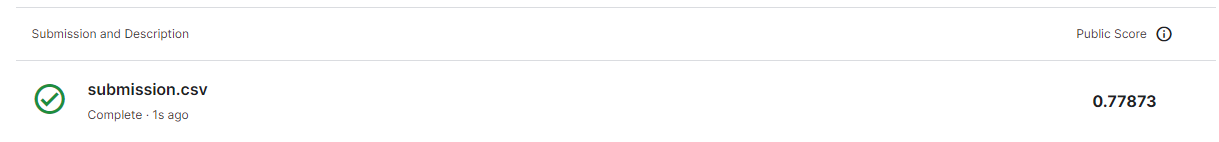

The above scores aren't terrible! It looks like our assumption will score roughly 0.65 on the leaderboard. There are lots of ways to potentially improve on this (TFIDF, LSA, LSTM / RNNs, the list is long!) - we will give any of them a shot!


Here's how we could use an RNN to solve the disaster tweets problem:


1.   Preprocess the tweet data by tokenizing the text and creating a vocabulary. we 
may also want to consider applying techniques such as stemming and lemmatization to help reduce the dimensionality of the data.
3. Pad the sequences of integers to ensure that all of the tweets have the same length.
4. Build an RNN model with an embedding layer, followed by one or more LSTM or GRU layers, and ending with a dense layer for classification.
5. Train the model on the disaster tweets data, using binary cross-entropy loss and an optimizer such as Adam.
6. Evaluate the model's performance on a held-out test set and fine-tune the model as needed to improve its accuracy.


We'll may also try and fine-tune: [twitter-roberta-sentiment](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment) for our purposes. If possible within the given schedule and resources. We will also see if we the results from the pre-trained model improve our model performance

## Setup Commands

In [ ]:
!git init .
!git remote add origin https://github.com/ArielFix/DLINtroProject.git
!git fetch
!git checkout main

Reinitialized existing Git repository in e:/Python Scripts/bci_mouse/DLINtroProject/test/.git/


fatal: remote origin already exists.


Branch 'main' set up to track remote branch 'main' from 'origin'.


Switched to a new branch 'main'


In [ ]:
!echo "This may take a while:"
%pip install -q -r requirements.txt

"This may take a while:"
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'e:\Python Scripts\bci_mouse\DLINtroProject\.venv\Scripts\python.exe -m pip install --upgrade pip' command.


## Troubleshooting

In [14]:
!python test_augs.py

Synonym Replace: hullo @world, let's see if the #augmentation go! GO! GO! GO!
Back Translate: Hello @world, let's see if the #Augmentation work! WALK! WALK! WALK!
Random Delete: Hello @world, 's  if  #augmentations work! GO! GO! GO!
Random Insertion: Hello @ world, let's see if the #augmentation augmentations work! GO hello! GO! GO!
Remove Duplicates: Hello @ world, let's see if the #augmentations work! GO
Swap Words: 's @ GO #let Hello see, the if augmentations work GO GO! world!!!


Using state Tel Aviv server backend.
[nltk_data] Downloading package omw-1.4 to C:\Users\Shaiel
[nltk_data]     Cohen\AppData\Roaming\nltk_data...
[nltk_data] Downloading package punkt to C:\Users\Shaiel
[nltk_data]     Cohen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Shaiel
[nltk_data]     Cohen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
